In [289]:
# Implementation of 
# [1] W. B. Lopes, A. Al-Nuaimi, and C. G. Lopes, “Geometric-Algebra LMS Adaptive 
# Filter and its Application to Rotation Estimation,” 
# IEEE Signal Process. Lett., vol. 23, no. 6, pp. 858–862, Jun. 2016, doi: 10.1109/LSP.2016.2558461.
#
# and optimalGain function is implemented from
# [2] A. Al-Nuaimi, E. Steinbach, W. B. Lopes, and C. G. Lopes, “6DOF point cloud alignment using 
# geometric algebra-based adaptive filtering,” in 
# 2016 IEEE Winter Conference on Applications of Computer Vision (WACV), Lake Placid, NY: 
# IEEE, Mar. 2016, pp. 1–9. doi: 10.1109/WACV.2016.7477642.
# 


In [271]:
import numpy as np
from clifford.g3 import *
from clifford.tools.g3 import generate_rotation_rotor, random_unit_vector
import matplotlib.pyplot as plt
import copy
from pyganja import GanjaScene, draw
rng = np.random.default_rng()
#blades # show blades

In [293]:
def pointsToAlgebra(point_list):
    """Convert a  list of points in R3 to points in G3"""
    out = list()
    for v in point_list:
        p = v[0]*e1 + v[1]*e2 + v[2]*e3
        out.append(p)
    
    return out
    
def randomG3Multivector(random_vector3 = None):
    """Generate a random point in G3"""
    if random_vector3 is None:
        random_vector3 = rng.standard_normal(3) * 0.1
    return random_vector3[0]*e1 + random_vector3[0]*e2 + random_vector3[0]*e3 

def g3ToVectorSpace(point_list):
    """Convert a list of points in G3 to R3"""
    out = list()
    for e in point_list:
        out.append(np.array([e.value[1], e.value[2],e.value[3]]))
    return np.array(out)

def planeCloud(normal = np.array([1.0, 0.0, 0.0]), d = 1.0, size = 100):
    """ Model plane is n.dot(p) - d = 0 where n is plane normal, 
        d is perpendicular distance from plane to origin and p is a point
        on the plane"""
    min_ = -10
    max_ = 10
    points = []
    for _ in range(size):
        x = rng.uniform(min_, max_)
        y = rng.uniform(min_, max_)
        z = d - normal[0]*x - normal[1]*y
        points.append([x,y,z])
    return np.array(points)

def cubeCloud(side_length = 1.0, size = 1000):
    """ Create a cube cloud as a set of planes"""
    normal_list = [[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]]
    plane_size = size // 6
    points = None
    for normal in normal_list:
        for direction in [-1.0, 1.0]:
            n = direction * np.array(normal)
            if points is None:
                points = planeCloud(normal = n, d = side_length, size = plane_size)
            else:
                points = np.vstack((points, planeCloud(normal = n, d = side_length, size = plane_size)))
    return points
            

def optimalGain(model_cloud, measure_cloud, rho = 1):
    """ Compute optimal gain based on dimensions and points of cloud
        based on [2]"""
    x = 0
    for p, q in zip(model_cloud, measure_cloud):
        x = x + (q^p)
        
    numerator = 0
    denominator = 0
    for p, q in zip(model_cloud, measure_cloud):
        numerator = numerator + (q * p * x).value[0]
        denominator = denominator + (q * ~x * p * x).value[0]
    
    return rho * numerator / denominator
    
    

#### Generate model cloud, ground truth rotor and measured point clouds in 3D

In [292]:
# Model point cloud
#np.random.seed(1)
size = 100
scale = 3
model_cloud = np.random.rand(100,3) * scale
model_cloud = cubeCloud(size = size)
model_cloud_g3 = pointsToAlgebra(model_cloud.tolist())

# Generate a ground truth motor
theta = np.pi / 4
t = -5*e1 + 3*e2 -np.pi*e3
M = generate_rotation_rotor(theta, e1, e2)
M = M.normal()

# Measured point cloud: obtained by adding rotating each point in the cloud
# and adding isotropic gaussian noise
measure_cloud_g3 = [ (M*e*~M) + randomG3Multivector() for e in model_cloud_g3]
measure_cloud = g3ToVectorSpace(measure_cloud_g3)

print(f"Model Cloud Size: {model_cloud.shape}, Measure Cloud Size: {measure_cloud.shape}")
print(f"Model Cloud head: \n{model_cloud[:5]}")
print(f"Measure Cloud head: \n{measure_cloud[:5]}")

NameError: name 'array' is not defined

In [280]:
# Draw point clouds
# Draw lines using original motor M and estimated motor Me
#sc = GanjaScene()
#[sc.add_object(e,color=0xFF0000,label='a') for e in model_cloud_g3]
#[sc.add_object(e,color=0x00FF00,label='b') for e in measure_cloud_g3]
#draw(sc, scale=0.1)

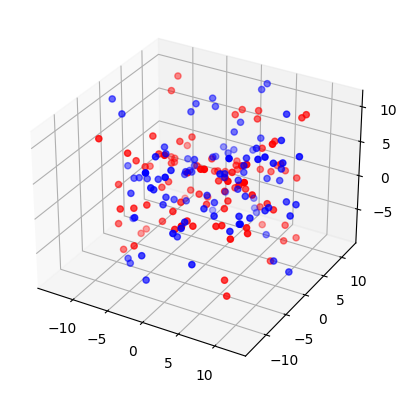

In [281]:
fig2 = plt.figure()
ax = fig2.add_subplot(projection='3d')
ax.scatter(model_cloud[:,0], model_cloud[:,1], model_cloud[:,2], color = "red")
ax.scatter(measure_cloud[:,0], measure_cloud[:,1], measure_cloud[:,2], color = "blue")

#### Define initial values for multirotor 

This is the initial rotor estimate. Also define some iteration parameters like the maximum number of iterations and residual threshold to stop iterations

In [285]:
max_iters = 20 # maximum number of iterations allowed to stop iterating
residual_thresh = 1e-6 # residual threshold to stop iterating
r_init = 0.5 + 0.5*e12 -0.5*e13 + 0.5*e23 # initial value of the rotor
r_init = r_init.normal()
r =  0.5 + 0.5*e12 -0.5*e13 + 0.5*e23 # optimized value of the rotor
r = r.normal()
mu_galms = 0.1

mu_optimal = optimalGain(model_cloud_g3, measure_cloud_g3)
print(f"Optimal gain: {mu_optimal}")

iters = 0 # current iteration number
residual = float(10.0) # current  residual
progress = {'cost': [], 'total_residual': [], 'i_residual': [], 'iters': []}
while(iters < max_iters and residual > residual_thresh):

    cost = 0.0
    for i, (p , q) in enumerate(zip(model_cloud_g3, measure_cloud_g3)):
        # Compute the instantaneous optimal step
        r = r_init + mu_optimal * (q ^ (r_init * p * ~r_init))*r_init
        # Normalize to respect  constraint |r| =1
        r = r.normal()
        # Get the residual between new value and previous value
        residual = 1.0 - (r*~r_init)(0).value[0] 
        # Start next iteration with the new value
        r_init = r
        
        # Sum the cost
        d = (q - (r_init * p * ~r_init))
        cost = cost + (d*~d)(0).value[0]
        progress['i_residual'].append(residual)
        
    
    progress['cost'].append(cost)
    progress['total_residual'].append(residual)
    progress['iters'].append(iters)

    iters += 1

    if (iters > max_iters):
        print(f"Finished due to maximum iterations: {iter}/{max_iters}")
    
    if (residual < residual_thresh):
        print(f"Finished due to residual: {residual}/{residual_thresh}")

print(f"Iters: {iters}, Residual: {residual} \n r: {r} |r| = {(r*~r)(0)} \n M: {M} |M| = {(M*~M)(0)}")

Optimal gain: 0.0004273273208048542
Finished due to residual: 9.026637072251376e-07/1e-06
Iters: 1, Residual: 9.026637072251376e-07 
 r: 0.92692 - (0.37499^e12) - (0.00429^e13) + (0.01376^e23) |r| = 1.0 
 M: 0.92388 - (0.38268^e12) |M| = 1.0


In [286]:
#### Compute error between ground truth and estimated rotor
e = 1 - (r*~M)(0)
e

0.00014

#### Plot Cost and Residual vs Iterations

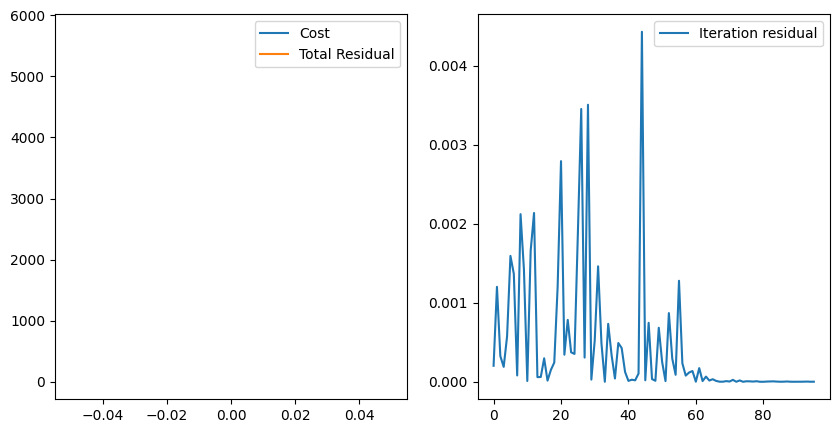

In [287]:
fig1 = plt.figure(figsize = (10, 5))
ax1 = fig1.add_subplot(1,2,1)
ax2 = fig1.add_subplot(1,2,2)
ax1.plot(progress['iters'], progress['cost'], label='Cost')
ax1.plot(progress['iters'], progress['total_residual'], label='Total Residual')
ax2.plot(progress['i_residual'], label='Iteration residual')
ax1.legend()
ax2.legend()